## Practico
### Introduccion al Aprendizaje Automatico

El objetivo consiste en explorar la aplicación de diferentes métodos de aprendizaje supervisado aprendidos 
en el curso, a través de experimentos reproducibles, y evaluando a su vez la conveniencia de uno u otro, 
así como la selección de diferentes hiperparámetros a partir del cálculo de las métricas pertinentes.

Para este practico se usara el dataset obtenido en el practico anterior
> Dataset Original: [here](https://drive.google.com/file/d/1wCNrWQbUd_bh1mdjZ-dg3g9y0r02JyQN/view?usp=sharing)

5. Optativo
* Graficar la curva ROC del modelo elegido en el punto anterior, Explicar.

Recuerden que la ciencia de datos es un proceso circular, continuo y no lineal. Es decir, si los datos requieren de mayor procesamiento para satisfacer las necesidades de algoritmos de ML (cualesquiera de ellos), vamos a volver a la etapa inicial para, por ejemplo, crear nuevas features, tomar decisiones diferentes sobre valores faltantes o valores atípicos (outliers), descartar features, entre otras.

1. Preparación

* Usar la columna monto movimiento como target para modelos de regresión.
* Con el objetivo de preparar los datos para los modelos de clasificacion.
  Crear una columna que indique si un cliente ha aumentado el monto de movimiento 
  mesual, comparando con el mes anterior. En donde 
  - 1 si el monto ha aumentado respecto del mes anterior (con un incremento mayor o igual al 10%)
  - 0 si no fue asi.
  > consideraciones: el primer mes del dataset, el valor es 0
  
* Las variables explicativas (variables X's) no deben estar muy correlacionadas entre ellas, 
  ya que la variabilidad de una y otra estarán explicando la misma parte de variabilidad de la variable dependiente. 
  Esto es lo que se conoce como multicolinealidad, lo cual deriva en la imposibilidad de estimar los parámetros 
  cuando la misma es exacta o en estimaciones muy imprecisas cuando la misma es aproximada. En el caso de encontrar multicolinealidad, 
  - Cómo se puede solucionar? Qué decisión tomarían al respecto?
  
* Es posible que sea necesario normalizar las features de nuestro dataset. En qué casos tendrá que implementarse normalización?


## 1. Preparación del conjunto de datos

In [28]:
import pyarrow
import fastparquet
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures

Para cargar el dataset

In [29]:
df = pd.read_parquet("df_final.parquet")

In [30]:
df

,dni_titular_movimiento,anio_mes_cupon,monto_ajustado,edad_cliente,antig_cliente,pca1,pca2,sexo_descripcion=Hombre,sexo_descripcion=Mujer,sexo_descripcion=Sin Datos,...,producto_naranja_movimiento=PP,producto_naranja_movimiento=TA,producto_naranja_movimiento=VI,producto_naranja_movimiento=ZE,tipo_producto_tarjeta_movimiento=0,tipo_producto_tarjeta_movimiento=22,tipo_producto_tarjeta_movimiento=3,tipo_producto_tarjeta_movimiento=32,tipo_producto_tarjeta_movimiento=4,tipo_producto_tarjeta_movimiento=42
0,000000b5aea2c9ea7cc155f6ebcef97f826,202008,-325.68,46.0,225,0.829899,-0.567124,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,000000b5aea2c9ea7cc155f6ebcef97f826,202009,-318.09,47.0,226,0.885993,-0.577546,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,000000b5aea2c9ea7cc155f6ebcef97f826,202010,-307.74,47.0,227,0.895144,-0.578143,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,000000b5aea2c9ea7cc155f6ebcef97f826,202011,-299.46,47.0,228,0.904295,-0.578743,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,000000b5aea2c9ea7cc155f6ebcef97f826,202012,-290.49,47.0,229,0.913446,-0.579343,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23203,000f0b73ebfa002a79a0642b82e87919904,202104,19956.87,64.0,24,-0.158297,-0.579022,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23204,000f0b73ebfa002a79a0642b82e87919904,202104,61555.59,64.0,24,-0.146730,-0.495411,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
23205,000f0b73ebfa002a79a0642b82e87919904,202104,96119.07,64.0,24,-0.137119,-0.425941,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
23206,000f0b73ebfa002a79a0642b82e87919904,202104,145677.63,64.0,24,-0.123339,-0.326332,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [31]:
df.shape

(23208, 54)

Seleccionamos las columnas con mayor variabilidad en el tiempo en cada dni

### 1.1 Selección de columnas

In [32]:
# TODO: mejorar
columnas = [x for x in df.columns if 'dni_titular' in x 
                       or 'anio_mes' in x 
                       or 'comercio_cat' in x
                       or 'producto_naranja' in x
                       or 'tipo_producto' in x
                       or 'monto_ajustado' in x
                       or 'antig_cliente' in x
                       or 'pca' in x]

In [33]:
df_obj = df[columnas].copy()

### 1.2 Creación de variable categórica 

In [34]:
df_obj.shape

(23208, 32)

Creación de un dataset con el DNI, Mes de Compra y el monto del mes. Se lo ordena para poder luego clasificarlo de forma secuencial.

In [35]:
df_dni_mes_mon = df_obj[['dni_titular_movimiento', 'anio_mes_cupon','monto_ajustado']] \
                        .groupby(['dni_titular_movimiento', 'anio_mes_cupon']).sum('monto_ajustado') \
                        .reset_index() \
                        .sort_values(by=['dni_titular_movimiento', 'anio_mes_cupon'])
df_dni_mes_mon

,dni_titular_movimiento,anio_mes_cupon,monto_ajustado
0,000000b5aea2c9ea7cc155f6ebcef97f826,202008,-325.68
1,000000b5aea2c9ea7cc155f6ebcef97f826,202009,-318.09
2,000000b5aea2c9ea7cc155f6ebcef97f826,202010,-307.74
3,000000b5aea2c9ea7cc155f6ebcef97f826,202011,-299.46
4,000000b5aea2c9ea7cc155f6ebcef97f826,202012,-290.49
...,...,...,...
7509,000f0b73ebfa002a79a0642b82e87919904,202101,801535.05
7510,000f0b73ebfa002a79a0642b82e87919904,202102,867100.92
7511,000f0b73ebfa002a79a0642b82e87919904,202103,183752.52
7512,000f0b73ebfa002a79a0642b82e87919904,202104,323309.16


Agregación de la nueva columna seteada en 0.

En la iteración, se le cambia el valor a 1 en caso de que cumpla con las condiciones preestablecidas.

In [36]:
df_dni_mes_mon['fg_aumentado'] = 0
for i in range(1,len(df_dni_mes_mon)):
    if (df_dni_mes_mon.iloc[i]['dni_titular_movimiento'] == df_dni_mes_mon.iloc[i-1]['dni_titular_movimiento']) \
        & (df_dni_mes_mon.iloc[i]['anio_mes_cupon'] > df_dni_mes_mon.iloc[i-1]['anio_mes_cupon']):
            var_mes = df_dni_mes_mon.iloc[i]['monto_ajustado'] - df_dni_mes_mon.iloc[i-1]['monto_ajustado']
            if (var_mes > (abs(df_dni_mes_mon.iloc[i-1]['monto_ajustado'])*0.1)):
                    df_dni_mes_mon.iloc[i,3] = 1

In [37]:
df_dni_mes_mon.head(30)

,dni_titular_movimiento,anio_mes_cupon,monto_ajustado,fg_aumentado
0,000000b5aea2c9ea7cc155f6ebcef97f826,202008,-325.68,0
1,000000b5aea2c9ea7cc155f6ebcef97f826,202009,-318.09,0
2,000000b5aea2c9ea7cc155f6ebcef97f826,202010,-307.74,0
3,000000b5aea2c9ea7cc155f6ebcef97f826,202011,-299.46,0
4,000000b5aea2c9ea7cc155f6ebcef97f826,202012,-290.49,0
5,000000b5aea2c9ea7cc155f6ebcef97f826,202101,-281.52,0
6,000000b5aea2c9ea7cc155f6ebcef97f826,202102,-273.93,0
7,000000b5aea2c9ea7cc155f6ebcef97f826,202103,-264.27,0
8,000000b5aea2c9ea7cc155f6ebcef97f826,202104,-256.68,0
9,000000b5aea2c9ea7cc155f6ebcef97f826,202105,-251.16,0


Borramos la columna monto, ya que no me interesa mostrarla cuando vaya a colocar el merge!

In [38]:
df_dni_mes_mon = df_dni_mes_mon.drop(columns=['monto_ajustado'])

In [39]:
df_dni_mes_mon = df_dni_mes_mon.rename(columns={'dni_titular_movimiento': 'dni_titular_movimiento_c', 'anio_mes_cupon': 'anio_mes_cupon_c'})
df_dni_mes_mon

,dni_titular_movimiento_c,anio_mes_cupon_c,fg_aumentado
0,000000b5aea2c9ea7cc155f6ebcef97f826,202008,0
1,000000b5aea2c9ea7cc155f6ebcef97f826,202009,0
2,000000b5aea2c9ea7cc155f6ebcef97f826,202010,0
3,000000b5aea2c9ea7cc155f6ebcef97f826,202011,0
4,000000b5aea2c9ea7cc155f6ebcef97f826,202012,0
...,...,...,...
7509,000f0b73ebfa002a79a0642b82e87919904,202101,1
7510,000f0b73ebfa002a79a0642b82e87919904,202102,0
7511,000f0b73ebfa002a79a0642b82e87919904,202103,0
7512,000f0b73ebfa002a79a0642b82e87919904,202104,1


Mersheamo!

In [40]:
df_obj = df_obj.merge( df_dni_mes_mon, 
             left_on=['dni_titular_movimiento', 'anio_mes_cupon'], 
             right_on=['dni_titular_movimiento_c', 'anio_mes_cupon_c']) \
        .drop(columns= ['dni_titular_movimiento_c','anio_mes_cupon_c'])

In [41]:
df_obj.shape

(23208, 33)

# Arreglar los comentarios de JUANI jajajaja ↑ ↑ ↑

### 1.3 Correlación entre las variables

In [42]:
corr = df_obj.corr()
corr=corr[['monto_ajustado']]
corr.loc[:,'abs_corr']=np.abs(corr['monto_ajustado'])
corr.sort_values(by='abs_corr',ascending = False).style.background_gradient()

,monto_ajustado,abs_corr
monto_ajustado,1.000000,1.000000
pca2,0.985298,0.985298
tipo_producto_tarjeta_movimiento=0,-0.305906,0.305906
producto_naranja_movimiento=PL,-0.296911,0.296911
tipo_producto_tarjeta_movimiento=3,0.287208,0.287208
producto_naranja_movimiento=PC,0.270787,0.270787
producto_naranja_movimiento=ZE,0.197086,0.197086
pca1,0.162149,0.162149
fg_aumentado,0.159426,0.159426
comercio_cat=0,-0.122827,0.122827


Estaria bueno hacer un scaterplot de todos contra todos

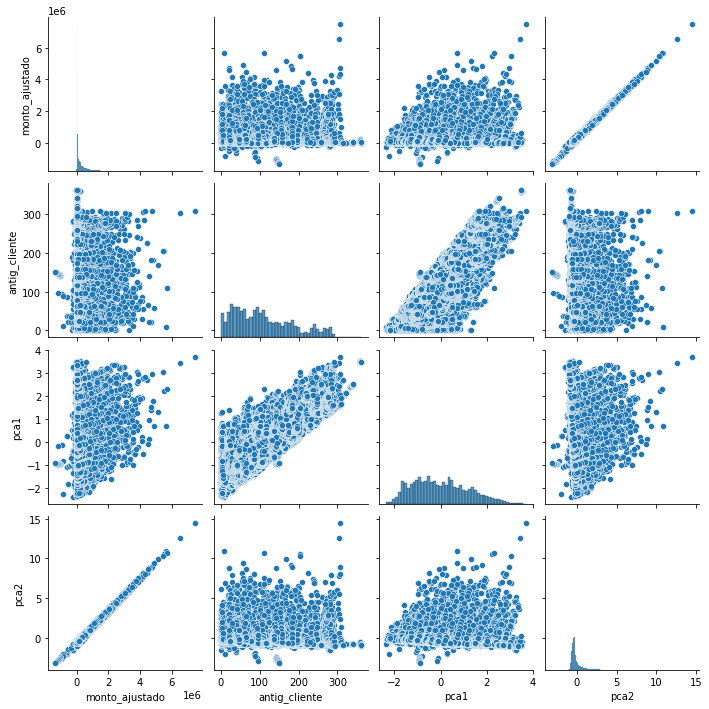

In [43]:
sns.pairplot(df_obj[['monto_ajustado', 'antig_cliente', 'pca1', 'pca2']])

### 1.4 Normalización

2. División

La primer tarea consiste en dividir el conjunto de datos, en conjuntos de entrenamiento (training), validación (validation).
evaluación (testing) 

<img 
     src="https://i.stack.imgur.com/pXAfX.png" 
     alt="Drawing" 
     style="width:40%;"
/>

* Para el conjunto de evaluacion tomar el ultimo mes del dataset.
* Para entrenamiento y validación utilizar aproximadamente 70-80% de los datos para entrenamiento y 30-20% para validación.
* Es conveniente mezclar los datos aleatoriamente a la hora de realizar la división de los datos? 
 > `shuffle=True`?
* Pensar si hacer de esta forma la división puede afectar la distribución espacial y temporal de los datos. Cuáles pueden ser las consecuencias?

## 2. División del conjunto de datos

In [44]:
y_reg = np.array(df_obj.loc[:, 'monto_ajustado'])

In [45]:
y_cla = np.array(df_obj.loc[:, 'fg_aumentado'])

In [46]:
X = df_obj.drop(['monto_ajustado', 'fg_aumentado'], axis=1)

In [79]:
# El conjunto de test se toma usando los datos de los ultimos 2 meses. 
X_test = X[X['anio_mes_cupon'] >= X['anio_mes_cupon'].max() - 1]
X_train = X[X['anio_mes_cupon'] < X['anio_mes_cupon'].max() - 1]

y_reg_test = df_obj[df_obj['anio_mes_cupon'] >= df_obj['anio_mes_cupon'].max() - 1]['monto_ajustado']
y_reg_train = df_obj[df_obj['anio_mes_cupon'] < df_obj['anio_mes_cupon'].max() - 1]['monto_ajustado']

y_cla_test = df_obj[df_obj['anio_mes_cupon'] >= df_obj['anio_mes_cupon'].max() - 1]['fg_aumentado']
y_cla_train = df_obj[df_obj['anio_mes_cupon'] < df_obj['anio_mes_cupon'].max() - 1]['fg_aumentado']

X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_train, y_reg_train, test_size=0.3, random_state=0, shuffle=False)
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_train, y_cla_train, test_size=0.3, random_state=0, shuffle=False)

In [81]:
print("Para entrenar modelos de regresión usaremos:",(X_train_r.shape, y_train_r.shape))
print("Para validar modelos de regresión usaremos:",(X_val_r.shape, y_val_r.shape))
print("Para testear modelos de regresión usaremos:",(X_test.shape, y_reg_test.shape))

Para entrenar modelos de regresión usaremos: ((15958, 31), (15958,))
Para validar modelos de regresión usaremos: ((6840, 31), (6840,))
Para testear modelos de regresión usaremos: ((410, 31), (410,))


In [82]:
print("Para entrenar modelos de clasificación usaremos:",(X_train_c.shape, y_train_c.shape))
print("Para validar modelos de clasificación usaremos:",(X_val_c.shape, y_val_c.shape))
print("Para testear modelos de clasificación usaremos:",(X_test.shape, y_cla_test.shape))

Para entrenar modelos de clasificación usaremos: ((15958, 31), (15958,))
Para validar modelos de clasificación usaremos: ((6840, 31), (6840,))
Para testear modelos de clasificación usaremos: ((410, 31), (410,))


3. Regresión

* Se puede explicar el monto de los movimientos en base a la antiguedad del cliente?
  - Usar un modelo polinomial.
  - Cuál será la función de costo utilizada?
  - Grafique las curvas de error en términos del grado del polinomio. 
  - Seleccione el modelo que mejor funcione, y grafique el modelo conjuntamente con los puntos.

* Regresión con más de una variable
  - Explicar, Por qué se eligieron dichas variables?
  - Grafique las curvas de error en términos del grado del polinomio. 
  - Se obtuvieron mejores resultados? Por qué?
* Evaluar el modelo
  - Una vez elegido el mejor modelo. validar con el cojunto evaluación
  
 
> Agregar vector de Bias, cuando lo crean pertinente. Cuándo hace falta y cuándo no? Por qué?

## 3. Regresión 

### 3.1 Regresión polinominal con la variable antigüedad

#### Sin vector de Bias

Primero visualizamos que tipo de relación puede existir entre la variable monto_ajustado y antigüedad.

<AxesSubplot:xlabel='antig_cliente', ylabel='monto_ajustado'>

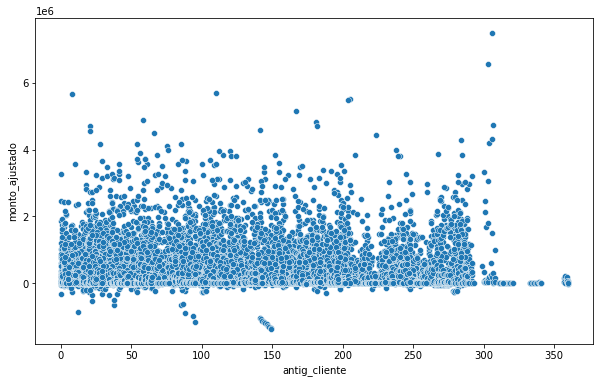

In [50]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_obj, x='antig_cliente', y='monto_ajustado', palette="pastel")

In [83]:
# Selección del feature antigüedad
X_train_antig = (X_train_r.loc[:, 'antig_cliente'].values).reshape(-1,1)
X_val_antig = (X_val_r.loc[:, 'antig_cliente'].values).reshape(-1,1)
#X_test_antig = (X_test.loc[:, 'antig_cliente'].values).reshape(-1,1)
X_train_antig.shape, X_val_antig.shape, X_test_antig.shape

((15958, 1), (6840, 1), (410, 1))

In [84]:
train_errors = []
valid_errors = []
degrees = [0,1,2,3,4,5,6,7,8,9,10,11,12]
for degree in degrees:
    # train:
    pf = PolynomialFeatures(degree)
    lr = LinearRegression(fit_intercept=False)
    model = make_pipeline(pf, lr)
    model.fit(X_train_antig, y_train_r)
    
    # predict:
    y_train_pred = model.predict(X_train_antig)
    y_valid_pred = model.predict(X_val_antig)
    
    train_error = mean_squared_error(y_train_r, y_train_pred)
    valid_error = mean_squared_error(y_val_r, y_valid_pred)
    train_errors.append(train_error)
    valid_errors.append(valid_error)
    print(f'Grado {degree}: Train error {train_error.round(3)},Valid error {valid_error.round(3)}') 

Grado 0: Train error 226267699773.186,Valid error 262858776086.369
Grado 1: Train error 225527551586.007,Valid error 261617257621.401
Grado 2: Train error 225488571627.946,Valid error 261383572475.194
Grado 3: Train error 225366995020.144,Valid error 261964929969.265
Grado 4: Train error 225366953615.763,Valid error 261967167972.072
Grado 5: Train error 225278690256.985,Valid error 261552575796.632
Grado 6: Train error 225012191203.147,Valid error 261016675706.087
Grado 7: Train error 230843983015.999,Valid error 264200449546.556
Grado 8: Train error 235711932757.73,Valid error 269505720176.881
Grado 9: Train error 240260739391.662,Valid error 276609705934.754
Grado 10: Train error 243873212853.593,Valid error 282879691123.01
Grado 11: Train error 254125601498.435,Valid error 293329685665.388
Grado 12: Train error 257645771315.636,Valid error 295492448394.17


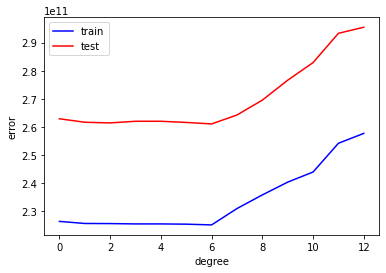

In [85]:
plt.plot(degrees, train_errors, color="blue", label="train")
plt.plot(degrees, valid_errors, color="red", label="test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("error")
plt.show()

Instaciamos el mejor modelo

In [54]:
# sin vector bais primero
degree = 6
pf = PolynomialFeatures(degree, include_bias=False)
lr = LinearRegression(fit_intercept=False)  
model = make_pipeline(pf, lr)

In [86]:
# Entrenamos el modelo
model.fit(X_train_antig, y_train_r)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=12)),
                ('linearregression', LinearRegression(fit_intercept=False))])

In [87]:
# Vemos los parametros
lr.coef_ , lr.intercept_

(array([ 7.59746528e-28,  6.91086266e-15,  2.43241322e-18,  1.81970935e-21,
         2.71709361e-19,  3.30409500e-17,  3.52576791e-15,  2.98706737e-13,
         1.54628828e-11, -2.10082053e-13,  1.06546469e-15, -2.38779413e-18,
         1.99377229e-21]), 0.0)

In [88]:
# Predigo
y_predic_antig = model.predict(X_val_antig)

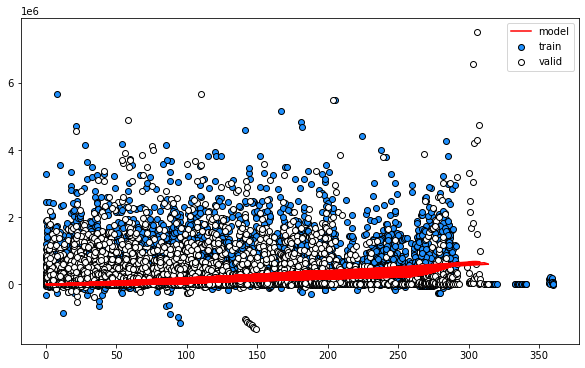

Train error: 257645771315.636444
Valid error: 295492448394.169495


In [89]:
plt.figure(figsize=(10,6))
plt.scatter(X_train_antig, y_train_r, color="dodgerblue", edgecolor="k", label="train")
plt.scatter(X_val_antig, y_val_r, color="white", edgecolor="k", label="valid")
plt.plot(X_val_antig, y_predic_antig, color="red", label="model") 
plt.legend()
plt.show()

print(f'Train error: {train_errors[degree]:f}')
print(f'Valid error: {valid_errors[degree]:f}')

#### Con vector de Bais

In [59]:
# sin vector bais primero
degree = 6
pf = PolynomialFeatures(degree)
lr = LinearRegression(fit_intercept=False)  
model = make_pipeline(pf, lr)

In [90]:
# Entrenamos el modelo
model.fit(X_train_antig, y_train_r)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=12)),
                ('linearregression', LinearRegression(fit_intercept=False))])

In [91]:
# Vemos los parametros
lr.coef_ , lr.intercept_

(array([ 7.59746528e-28,  6.91086266e-15,  2.43241322e-18,  1.81970935e-21,
         2.71709361e-19,  3.30409500e-17,  3.52576791e-15,  2.98706737e-13,
         1.54628828e-11, -2.10082053e-13,  1.06546469e-15, -2.38779413e-18,
         1.99377229e-21]), 0.0)

In [92]:
# Predigo
y_predic_antig_2 = model.predict(X_val_antig)

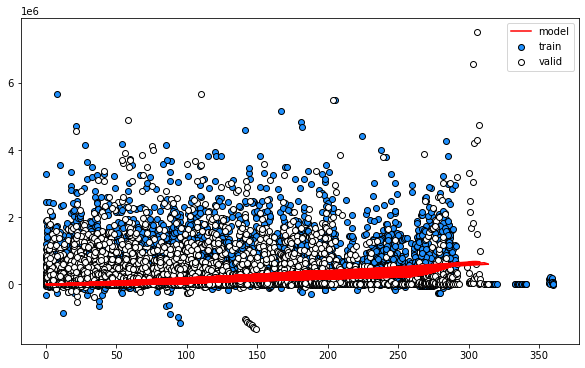

Train error: 257645771315.636444
Valid error: 295492448394.169495


In [93]:
plt.figure(figsize=(10,6))
plt.scatter(X_train_antig, y_train_r, color="dodgerblue", edgecolor="k", label="train")
plt.scatter(X_val_antig, y_val_r, color="white", edgecolor="k", label="valid")
plt.plot(X_val_antig, y_predic_antig_2, color="red", label="model") 
plt.legend()
plt.show()

print(f'Train error: {train_errors[degree]:f}')
print(f'Valid error: {valid_errors[degree]:f}')

### Regresion lineal con pca2

<AxesSubplot:xlabel='pca2', ylabel='monto_ajustado'>

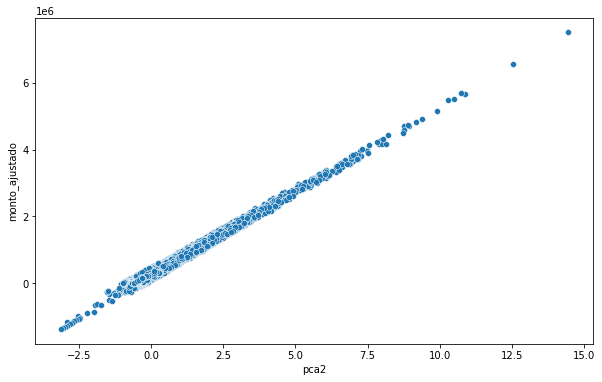

In [64]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_obj, x='pca2', y='monto_ajustado', palette="pastel")

In [94]:
# Selección del feature pca2
X_train_pca2 = (X_train_r.loc[:, 'pca2'].values).reshape(-1,1)
X_val_pca2 = (X_val_r.loc[:, 'pca2'].values).reshape(-1,1)
#X_test_pca2 = (X_test_r.loc[:, 'pca2'].values).reshape(-1,1)
X_train_pca2.shape, X_val_pca2.shape, X_test_pca2.shape

((15958, 1), (6840, 1), (410, 1))

In [95]:
# Entrenamiento
reg = LinearRegression()
reg.fit(X_train_pca2, y_train_r)

print(f'W:{reg.coef_, reg.intercept_}')

W:(array([484101.31984854]), 264649.44050452916)


In [96]:
# Validaciom
y_predict=reg.predict(X_val_pca2)
print(f'Train error: {reg.score(X_train_pca2,y_train_r):f}')
print(f'Test error: {reg.score(X_val_pca2, y_val_r):f}')

Train error: 0.967314
Test error: 0.975975


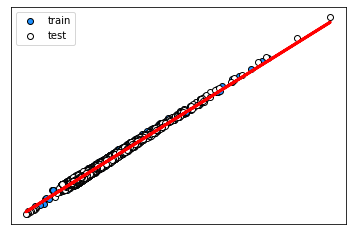

In [98]:
plt.scatter(X_train_pca2, y_train_r, color="dodgerblue",edgecolor="k", label="train")
plt.scatter(X_val_pca2, y_val_r, color="white", edgecolor="k", label="test")
plt.plot(X_val_pca2, y_predict, color='red', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.legend()
plt.show()

## Clasificación
* El TARGET se encuentra desbalanceado?
* Entrenar modelos lineales y No lineales de clasificación para predecir la variable objetivo.
* Seleccionar distintos valores para los hiperparámetros de los modelos usando `GridSearchCV`.
* Evaluar el modelo con el cojunto evaluación usando.
   - Accuracy
   - Precision
   - Recall
   - F1
   - matriz de confusión
* Explicar el por qué de cada resultado.

### Regresión Logistica

In [72]:
y_cla_test.value_counts()

Como podemos ver, existe un desbalance entre la clase 1 y la clase 0, con una relacion cercana a 5:1

In [70]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lreg = LogisticRegression(random_state=0)
lreg.fit(X_train, y_cla_test)